## **5. Predictive Modeling**

### **5.1 Introduction**

In this project, we will develop a predictive model using two different types of datasets:
- **Default Dataset**: The original dataset without any modifications.
- **Dataset with Imputed Missing Values**: A dataset where missing values have been filled (imputed).

We will conduct four main experiments to evaluate the model's performance:

1. **Experiment 1 - Model Benchmarking**: In this stage, we will compare the model's performance across the two datasets without applying resampling or tuning. The dataset with the highest performance will be selected for use in the subsequent experiments.

2. **Experiment 2 - Model with Imbalance Treatment**: In this experiment, we will apply resampling techniques, such as SMOTE and NearMiss, to address class imbalance and train the model using the dataset selected from Experiment 1.

3. **Experiment 3 - Model with Feature Selection**: We will select the most consistent model from Experiments 1 and 2 to perform feature selection using Recursive Feature Elimination (RFE) and Predictive Power Score (PPS).

4. **Experiment 4 - Model with Tuning**: In this experiment, we will perform hyperparameter tuning to optimize the model's performance. We will also experiment with different feature sets, including all features, features selected by RFE, and features identified by PPS.

The goal of these experiments is to identify the combination of dataset, resampling technique, feature selection, and tuning that results in the best-performing predictive model.

### **5.2 Import Library**

In [1]:
# Array and DataFrame
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Feature Engineering
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

# Imbalanced Classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score

# Evaluation Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay,
    recall_score, accuracy_score, precision_score, make_scorer
)

# Serialization
import pickle

# Timing
import time

# Hide Warnings
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### **5.3 Data Preprocessing**

> In this phase, we will start by importing the data and splitting the dataset into training, validation, and testing sets. We will also handle data encoding as necessary. Following this, we will prepare the pipeline for the machine learning experiments by defining the scoring metrics, setting up the models, and configuring the pipeline.

#### **5.3.1 Import Dataset**

In [2]:
df1 = pd.read_csv('dataset_default.csv').drop(columns='Unnamed: 0')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39400 entries, 0 to 39399
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39400 non-null  int64  
 1   job             39400 non-null  object 
 2   marital         39400 non-null  object 
 3   education       39400 non-null  object 
 4   default         39400 non-null  object 
 5   housing         39400 non-null  object 
 6   loan            39400 non-null  object 
 7   contact         39400 non-null  object 
 8   month           39400 non-null  object 
 9   day_of_week     39400 non-null  object 
 10  campaign        39400 non-null  int64  
 11  pdays           39400 non-null  int64  
 12  previous        39400 non-null  int64  
 13  poutcome        39400 non-null  object 
 14  emp.var.rate    39400 non-null  float64
 15  cons.price.idx  39400 non-null  float64
 16  cons.conf.idx   39400 non-null  float64
 17  euribor3m       39400 non-null 

In [3]:
df2 = pd.read_csv('dataset__with_fillin_unknown.csv').drop(columns='Unnamed: 0')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39065 entries, 0 to 39064
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39065 non-null  int64  
 1   job             39065 non-null  object 
 2   marital         39065 non-null  object 
 3   education       39065 non-null  object 
 4   default         39065 non-null  object 
 5   housing         39065 non-null  object 
 6   loan            39065 non-null  object 
 7   contact         39065 non-null  object 
 8   month           39065 non-null  object 
 9   day_of_week     39065 non-null  object 
 10  campaign        39065 non-null  int64  
 11  pdays           39065 non-null  int64  
 12  previous        39065 non-null  int64  
 13  poutcome        39065 non-null  object 
 14  emp.var.rate    39065 non-null  float64
 15  cons.price.idx  39065 non-null  float64
 16  cons.conf.idx   39065 non-null  float64
 17  euribor3m       39065 non-null 

#### **5.3.2 Splitting Data**

In [4]:
X1 = df1.drop(['deposit'], axis=1)
y1 = df1['deposit']

# split into train+val and test
X_train_val1, X_test1, y_train_val1, y_test1 = train_test_split(X1, y1, test_size=0.20, stratify=y1, random_state=42)

# split into train and val
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train_val1, y_train_val1, test_size=0.20 ,stratify=y_train_val1, random_state=42)

In [5]:
X2 = df2.drop(['deposit'], axis=1)
y2 = df2['deposit']

# split into train+val and test
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(X2, y2, test_size=0.20, stratify=y2, random_state=42)

# split into train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=0.20 ,stratify=y_train_val2, random_state=42)

#### **5.3.3 Feature Engineering**

In [6]:
# Mapping for ordinal encoding
ordinal_mapping = [
    {'col': 'education',
    'mapping': {'illiterate': 1, 'basic 4y': 2, 'basic 6y': 3, 'basic 9y': 4, 'high school': 5, 'professional course': 6, 'university degree': 7, 'Unknown': 8, None: 0}}
]

In [7]:
# define preprocessor1 as a ColumnTransformer to handle feature transformation.
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['marital', 'day_of_week', 'poutcome', 'default', 'contact', 'housing', 'loan']),
    ('ordinal', ce.OrdinalEncoder(mapping=ordinal_mapping), ['education']),
    ('binary', ce.BinaryEncoder(), ['job', 'month']) 
], remainder='passthrough')

In [8]:
# fit and transform training data 1
X_train1_transformed = preprocessor.fit_transform(X_train1)
X_val1_transformed = preprocessor.transform(X_val1)

In [9]:
# fit and transform training data 2
X_train2_transformed = preprocessor.fit_transform(X_train2)
X_val2_transformed = preprocessor.transform(X_val2)

In [10]:
# define scaler 
scaler = RobustScaler()

In [11]:
# define model algoritm 
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
grb = GradientBoostingClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0, verbose = -1)


models = [
    ('Logistic Regressionn', logreg),
    ('K-Nearest Neighbors', knn),
    ('Decision Tree', dtree),
    ('Random Forest', rf), 
    ('Gradient Boosting', grb),
    ('AdaBoost', ada),
    ('XGBoost', xgb),
    ('LightGBM', lgbm)
]

### **5.4 Experiment 1: Benchmarking Models**

> This experiment is focused on creating model benchmarks using different algorithms. The primary goal of the baseline model is to **select the dataset with the best performance**. Stratified k-fold cross-validation is employed to ensure that each fold of the training set maintains the same proportion of the target class label, which is crucial due to the imbalanced distribution of customers who made a deposit and those who did not in the target variable. This technique mitigates potential bias in certain folds if the classes are not stratified. Additionally, since this experiment is for benchmarking, the aim is to assess how well the **models perform using a basic experimental** setup without applying any resampling techniques to address the uneven distribution in the target variable.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold

def cv_model(X_train, y_train, models, scoring="precision"):
    list_name = []
    list_precision = []
    list_training_time = []
    list_precision_std = []

    for name, algorithm in models:
        if algorithm in [knn, logreg]: 
            pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("scaler", scaler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("algorithm", algorithm)
            ])

        start_time = time.time()    
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Lakukan cross-validation
        model_cv = cross_validate(
            pipe_model,
            X_train,
            y_train,
            cv=skfold,
            scoring=scoring,
            error_score="raise",
            n_jobs=-1
        )

        end_time = time.time() 
        training_time = end_time - start_time 

        list_name.append(name)
        list_precision.append(round(model_cv["test_score"].mean(), 3))  # 'test_score' adalah output default dari cross_validate
        list_precision_std.append(round(model_cv["test_score"].std(), 3))
        list_training_time.append(round(training_time, 3))

    result = pd.DataFrame({
        "Model": list_name,
        "mean_precision": list_precision,
        "std_precision": list_precision_std,
        "training_time": list_training_time
    })

    return result.sort_values("mean_precision", ascending=False)

In [13]:
def model_eval(models, X_train, X_val, y_train, y_val):
    list_name = []
    list_precision_val = []

    for name, algorithm in models:
        if algorithm in [knn, logreg]: 
            pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("scaler", scaler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", preprocessor),
                ("algorithm", algorithm)
            ])
        
        # Fit the model on the training data
        pipe_model.fit(X_train, y_train)

        # Predict on the validation set
        y_pred_val = pipe_model.predict(X_val)

        # Menghitung nilai precision
        precision_val = precision_score(y_val, y_pred_val)

        # Append results
        list_name.append(name)
        list_precision_val.append(round(precision_val, 3))

    # Create DataFrame for validation results
    result = pd.DataFrame({
        "Model": list_name,
        "precision": list_precision_val
    })

    # Return results sorted by precision
    return result.sort_values("precision", ascending=False)

#### **5.4.1 Dataset Default**

In [14]:
df1_benchmarking_cv = cv_model(X_train1, y_train1, models)
df1_benchmarking_cv

,Model,mean_precision,std_precision,training_time
5,AdaBoost,0.677,0.029,4.395
4,Gradient Boosting,0.662,0.021,14.451
0,Logistic Regressionn,0.648,0.006,7.195
7,LightGBM,0.623,0.032,2.226
6,XGBoost,0.573,0.032,1.230
1,K-Nearest Neighbors,0.546,0.016,6.077
3,Random Forest,0.541,0.013,5.509
2,Decision Tree,0.284,0.011,5.966


In [15]:
# Pastikan untuk menggunakan nama fungsi yang benar
df1_benchmarking_val = model_eval(models, X_train1, X_val1, y_train1, y_val1)
df1_benchmarking_val

,Model,precision
5,AdaBoost,0.648
0,Logistic Regressionn,0.609
4,Gradient Boosting,0.607
7,LightGBM,0.569
6,XGBoost,0.547
3,Random Forest,0.514
1,K-Nearest Neighbors,0.501
2,Decision Tree,0.316


#### **5.4.2 Dataset With Unknown Filled**

In [16]:
df2_benchmarking_cv = cv_model(X_train2, y_train2, models)
df2_benchmarking_cv

,Model,mean_precision,std_precision,training_time
5,AdaBoost,0.660,0.011,3.801
0,Logistic Regressionn,0.648,0.038,1.241
4,Gradient Boosting,0.643,0.035,10.795
7,LightGBM,0.618,0.037,1.505
6,XGBoost,0.573,0.017,0.932
1,K-Nearest Neighbors,0.538,0.027,1.569
3,Random Forest,0.538,0.014,4.464
2,Decision Tree,0.291,0.015,0.577


In [17]:
df2_benchmarking_val = model_eval(models, X_train2, X_val2, y_train2, y_val2)
df2_benchmarking_val

,Model,precision
5,AdaBoost,0.641
4,Gradient Boosting,0.639
7,LightGBM,0.623
0,Logistic Regressionn,0.611
6,XGBoost,0.568
1,K-Nearest Neighbors,0.540
3,Random Forest,0.501
2,Decision Tree,0.307


#### **5.4.3 Comparison Dataset Performance**

In [18]:
comparison_result = df1_benchmarking_cv.set_index('Model').join(df1_benchmarking_val.set_index('Model'), rsuffix='_val')
comparison_result.drop(columns=['std_precision','training_time'], axis=1, inplace=True)
comparison_result['diff'] = (comparison_result['precision'] - comparison_result['mean_precision']).abs()
comparison_result = comparison_result.sort_values(by='precision', ascending=False)
comparison_result


,mean_precision,precision,diff
Model,,,
AdaBoost,0.677,0.648,0.029
Logistic Regressionn,0.648,0.609,0.039
Gradient Boosting,0.662,0.607,0.055
LightGBM,0.623,0.569,0.054
XGBoost,0.573,0.547,0.026
Random Forest,0.541,0.514,0.027
K-Nearest Neighbors,0.546,0.501,0.045
Decision Tree,0.284,0.316,0.032


In [19]:
comparison_result = df2_benchmarking_cv.set_index('Model').join(df2_benchmarking_val.set_index('Model'), rsuffix='_val')
comparison_result.drop(columns=['std_precision','training_time'], axis=1, inplace=True)
comparison_result['diff'] = (comparison_result['precision'] - comparison_result['mean_precision']).abs()
comparison_result = comparison_result.sort_values(by='precision', ascending=False)
comparison_result


,mean_precision,precision,diff
Model,,,
AdaBoost,0.660,0.641,0.019
Gradient Boosting,0.643,0.639,0.004
LightGBM,0.618,0.623,0.005
Logistic Regressionn,0.648,0.611,0.037
XGBoost,0.573,0.568,0.005
K-Nearest Neighbors,0.538,0.540,0.002
Random Forest,0.538,0.501,0.037
Decision Tree,0.291,0.307,0.016


> **Insight:**

- The experiment results show that the default dataset, which was not modified, provides the best performance. In other words, the dataset that still contains 'unknown' values demonstrates better model performance. This proves that, despite the importance of preprocessing, the default dataset yielded better results in this context.

- In the basic setups (basic pipeline plus classifier), this enhancement has allowed Logistic Regression, Gradient Boosting, and Adaboost to outperform other classifiers, demonstrating their effectiveness in leveraging the refined dataset. Specifically, Logistic Regression achieved a precision score of 0.648 ± 0.006, Gradient Boosting scored 0.662 ± 0.021, and Adaboost reached 0.677 ± 0.029.

### **5.5 Experiment 2: Class Imbalance Treatment**

> As we demonstrated earlier in Section 3, the distribution between deposit class 1 and class 0 is uneven. In this phase, we apply various resampling techniques to the dataset default from the baseline experiments. We use:
- SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples for the minority class to balance the dataset. This technique creates new, synthetic instances of the minority class, enabling the model to better learn and generalize from the minority class.
- NearMiss: Undersamples the majority class by selecting samples that are closest to the minority class. This approach reduces the imbalance by focusing on the most challenging samples for classification, thereby improving the model’s performance on the minority class.

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import time

def cv_model_resampler(X_train, y_train, models, resampler=None):
    list_name = []
    list_precision = []
    list_precision_std = []
    list_training_time = []

    # Map string to resampler object if needed
    if resampler == 'SMOTE':
        resampler = SMOTE(random_state=42)
    elif resampler == 'NearMiss':
        resampler = NearMiss()
    elif resampler is None:
        resampler = None  # Explicitly set to None if no resampling

    for name, algorithm in models:
        steps = [("preprocessing", preprocessor)]

        if algorithm in [knn, logreg]: 
            steps.append(("scaler", scaler))

        if resampler:
            steps.append(("resampler", resampler))

        steps.append(("algorithm", algorithm))

        # Use ImbPipeline for all cases
        pipe_model = ImbPipeline(steps)

        start_time = time.time()
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform cross-validation
        model_cv = cross_validate(
            pipe_model,
            X_train,
            y_train,
            cv=skfold,
            scoring='precision',
            error_score='raise',
            n_jobs=-1
        )

        end_time = time.time() 
        training_time = end_time - start_time 
        
        list_name.append(name)
        list_precision.append(round(model_cv["test_score"].mean(), 3))
        list_precision_std.append(round(model_cv["test_score"].std(), 3))
        list_training_time.append(round(training_time, 3))
    
    result = pd.DataFrame({
        "Model": list_name,
        "mean_precision": list_precision,
        "std_precision": list_precision_std,
        "training_time": list_training_time
    })

    return result.sort_values("mean_precision", ascending=False)


In [21]:
def resampler_model_eval(models, X_train, X_val, y_train, y_val, resampler):
    list_name = []
    list_precision_val = []

    # Map string to resampler object if needed
    if resampler == 'SMOTE':
        resampler = SMOTE(random_state=42)
    elif resampler == 'NearMiss':
        resampler = NearMiss(version=3)
    else:
        resampler=None

    for name, algorithm in models:
        if algorithm in [knn, logreg]: 
            pipe_model = ImbPipeline([
                ("preprocessing", preprocessor),
                ("scaler", scaler),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = ImbPipeline([
                ("preprocessing", preprocessor),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
        
        # Fit the model on the training data
        pipe_model.fit(X_train, y_train)

        # Predict on the validation set
        y_pred_val = pipe_model.predict(X_val)

        # Menghitung nilai precision
        precision_val = precision_score(y_val, y_pred_val)

        # Append results
        list_name.append(name)
        list_precision_val.append(round(precision_val, 3))

    # Create DataFrame for validation results
    result = pd.DataFrame({
        "Model": list_name,
        "precision": list_precision_val
    })

    # Return results sorted by precision
    return result.sort_values("precision", ascending=False)

#### **5.5.1 SMOTE**

In [22]:
smote_results = cv_model_resampler(X_train1, y_train1, models, 'SMOTE')
smote_results

,Model,mean_precision,std_precision,training_time
7,LightGBM,0.588,0.013,4.608
6,XGBoost,0.567,0.017,3.302
4,Gradient Boosting,0.565,0.014,29.341
3,Random Forest,0.528,0.014,9.454
5,AdaBoost,0.493,0.010,8.123
0,Logistic Regressionn,0.329,0.008,1.759
2,Decision Tree,0.284,0.012,1.194
1,K-Nearest Neighbors,0.253,0.005,2.678


In [23]:
# Pastikan untuk menggunakan nama fungsi yang benar
smote_resampler_val = resampler_model_eval(models, X_train1, X_val1, y_train1, y_val1, 'SMOTE')
smote_resampler_val

,Model,precision
7,LightGBM,0.574
4,Gradient Boosting,0.554
6,XGBoost,0.553
5,AdaBoost,0.484
3,Random Forest,0.481
0,Logistic Regressionn,0.320
2,Decision Tree,0.286
1,K-Nearest Neighbors,0.249


In [24]:
combined_results = smote_results.set_index('Model').join(smote_resampler_val.set_index('Model'), rsuffix='_val')
combined_results.drop(columns=['std_precision','training_time'], axis=1, inplace=True)
combined_results['diff'] = (combined_results['precision'] - combined_results['mean_precision']).abs()
combined_results = combined_results.sort_values(by='precision', ascending=False)
combined_results

,mean_precision,precision,diff
Model,,,
LightGBM,0.588,0.574,0.014
Gradient Boosting,0.565,0.554,0.011
XGBoost,0.567,0.553,0.014
AdaBoost,0.493,0.484,0.009
Random Forest,0.528,0.481,0.047
Logistic Regressionn,0.329,0.320,0.009
Decision Tree,0.284,0.286,0.002
K-Nearest Neighbors,0.253,0.249,0.004


#### **5.5.2 NearMiss**

In [25]:
nearmiss_results = cv_model_resampler(X_train1, y_train1, models, "NearMiss")
nearmiss_results

,Model,mean_precision,std_precision,training_time
1,K-Nearest Neighbors,0.200,0.005,1.229
0,Logistic Regressionn,0.161,0.003,1.451
4,Gradient Boosting,0.155,0.003,1.929
5,AdaBoost,0.155,0.003,1.734
3,Random Forest,0.152,0.002,1.688
7,LightGBM,0.149,0.002,1.605
6,XGBoost,0.147,0.003,1.229
2,Decision Tree,0.145,0.003,0.917


In [26]:
# Pastikan untuk menggunakan nama fungsi yang benar
nearmiss_resampler_val = resampler_model_eval(models, X_train1, X_val1, y_train1, y_val1, 'NearMiss')
nearmiss_resampler_val

,Model,precision
0,Logistic Regressionn,0.198
4,Gradient Boosting,0.167
5,AdaBoost,0.165
7,LightGBM,0.163
3,Random Forest,0.159
6,XGBoost,0.154
1,K-Nearest Neighbors,0.141
2,Decision Tree,0.137


In [27]:
combined_results = nearmiss_results.set_index('Model').join(nearmiss_resampler_val.set_index('Model'), rsuffix='_val')
combined_results.drop(columns=['std_precision','training_time'], axis=1, inplace=True)
combined_results['diff'] = (combined_results['precision'] - combined_results['mean_precision']).abs()
combined_results = combined_results.sort_values(by='precision', ascending=False)
combined_results

,mean_precision,precision,diff
Model,,,
Logistic Regressionn,0.161,0.198,0.037
Gradient Boosting,0.155,0.167,0.012
AdaBoost,0.155,0.165,0.010
LightGBM,0.149,0.163,0.014
Random Forest,0.152,0.159,0.007
XGBoost,0.147,0.154,0.007
K-Nearest Neighbors,0.200,0.141,0.059
Decision Tree,0.145,0.137,0.008


> **Insight:**

Using resampling methods, SMOTE produced higher scores compared to NearMiss, demonstrating its effectiveness in handling imbalanced data.
The top three models in this experiment are LightGBM, XGBoost, and Gradient Boosting. However, none of these models showed better precision scores compared to the benchmark model from Experiment 1. In fact, after applying SMOTE to address data imbalance, the precision scores for these three models decreased. 

#### **5.5.4 Comparison Resampling Method**

| Model               | Benchmarking Precision  | SMOTE Precision  | NearMiss Precision  |
|---------------------|-------------------------|------------------|---------------------|
| Logistic Regression | **0.648**               | 0.329            | **0.161**           |
| Gradient Boosting   | **0.662**               | **0.565**        | **0.155**           |
| AdaBoost            | **0.677**               | 0.493            | 0.155               |
| LightGBM            | 0.623                   | **0.588**        | 0.149               |
| XGBoost             | 0.573                   | **0.567**        | 0.147               |
| K-Nearest Neighbors | 0.546                   | 0.253            | **0.200**           |
| Random Forest       | 0.541                   | 0.528            | 0.152               |
| Decision Tree       | 0.284                   | 0.284            | 0.145               |


> Overall, Gradient Boosting demonstrates strong consistency across the experiments that have been conducted. Although its precision results vary, it consistently ranks in the top-3 in each experiment, and its benchmarking model results show the best performance. Therefore, Gradient Boosting is selected as the primary model for the next phase, which is the Recursive Feature Elimination (RFE) experiment and Predictive Power Score (PPS). This choice reflects its robustness and potential for further improvement through feature selection.

### **5.6 Experiment 3: Feature Selection**

#### **5.6.1 RFE**

> In this phase of our project, we will focus on evaluating and selecting the most relevant features to improve model performance. Feature selection is a crucial step in enhancing the efficiency and accuracy of machine learning models by identifying the most informative variables and eliminating redundant or irrelevant ones. To achieve this, we will apply two distinct feature selection techniques: Recursive Feature Elimination (RFE) and the Predictive Power Score (PPS) Matrix. RFE will help us rank and select features based on their impact on model performance, while the PPS Matrix will provide insights into the interactions between features and their predictive power. These methods will be applied to the Gradient Boosting model, which has shown strong performance across various experiments, to further refine and optimize its predictive capabilities.

In [28]:
from sklearn.feature_selection import RFE
grb = GradientBoostingClassifier(random_state=0)

In [29]:
results = []
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for n_features in range(15, 20):
    rfe = RFE(estimator=grb, n_features_to_select=n_features)

    rfe_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('rfe', rfe)
    ])

    # Transform and select features
    X_train1_transformed = rfe_pipeline.fit_transform(X_train1, y_train1)
    all_feature_names = preprocessor.get_feature_names_out()
    selected_features = [feature for feature, rank in zip(all_feature_names, rfe.ranking_) if rank == 1]
    dropped_features = [feature for feature, rank in zip(all_feature_names, rfe.ranking_) if rank != 1]

    # Model pipeline
    model_pipeline = Pipeline([('model', grb)])

    mean_precision_score = cross_val_score(
        model_pipeline,
        X_train1_transformed,
        y_train1, 
        cv=cv, 
        scoring='precision',
        error_score='raise'
    ).mean()

    results.append({
        'n_features': n_features,
        'selected_features': selected_features,
        'dropped_features': dropped_features,
        'mean_precision_score_cv': mean_precision_score
    })

results_df = pd.DataFrame(results)
results_df.sort_values('mean_precision_score_cv', ascending=False, inplace=True)
results_df


,n_features,selected_features,dropped_features,mean_precision_score_cv
4,19,"[onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__day_of_week_tue, onehot__day_of_week_wed, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, ordinal__education, remainder__age, remainder__campaign, remainder__pdays, remainder__previous, remainder__emp.var.rate, remainder__cons.price.idx, remainder__cons.conf.idx, remainder__euribor3m, remainder__nr.employed]","[onehot__marital_divorced, onehot__marital_married, onehot__marital_single, onehot__marital_unknown, onehot__day_of_week_thu, onehot__poutcome_nonexistent, onehot__default_unknown, onehot__default_yes, onehot__housing_no, onehot__housing_unknown, onehot__housing_yes, onehot__loan_no, onehot__loan_unknown, onehot__loan_yes, binary__job_0, binary__job_1, binary__job_2, binary__job_3, binary__month_0, binary__month_1, binary__month_2, binary__month_3]",0.672286
0,15,"[onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, remainder__age, remainder__campaign, remainder__pdays, remainder__emp.var.rate, remainder__cons.price.idx, remainder__cons.conf.idx, remainder__euribor3m, remainder__nr.employed]","[onehot__marital_divorced, onehot__marital_married, onehot__marital_single, onehot__marital_unknown, onehot__day_of_week_thu, onehot__day_of_week_tue, onehot__day_of_week_wed, onehot__poutcome_nonexistent, onehot__default_unknown, onehot__default_yes, onehot__housing_no, onehot__housing_unknown, onehot__housing_yes, onehot__loan_no, onehot__loan_unknown, onehot__loan_yes, ordinal__education, binary__job_0, binary__job_1, binary__job_2, binary__job_3, binary__month_0, binary__month_1, binary__month_2, binary__month_3, remainder__previous]",0.671875
2,17,"[onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__day_of_week_tue, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, remainder__age, remainder__campaign, remainder__pdays, remainder__previous, remainder__emp.var.rate, remainder__cons.price.idx, remainder__cons.conf.idx, remainder__euribor3m, remainder__nr.employed]","[onehot__marital_divorced, onehot__marital_married, onehot__marital_single, onehot__marital_unknown, onehot__day_of_week_thu, onehot__day_of_week_wed, onehot__poutcome_nonexistent, onehot__default_unknown, onehot__default_yes, onehot__housing_no, onehot__housing_unknown, onehot__housing_yes, onehot__loan_no, onehot__loan_unknown, onehot__loan_yes, ordinal__education, binary__job_0, binary__job_1, binary__job_2, binary__job_3, binary__month_0, binary__month_1, binary__month_2, binary__month_3]",0.670052
3,18,"[onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__day_of_week_tue, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, ordinal__education, remainder__age, remainder__campaign, remainder__pdays, remainder__previous, remainder__emp.var.rate, remainder__cons.price.idx, remainder__cons.conf.idx, remainder__euribor3m, remainder__nr.employed]","[onehot__marital_divorced, onehot__marital_married, onehot__marital_single, onehot__marital_unknown, onehot__day_of_week_thu, onehot__day_of_week_wed, onehot__poutcome_nonexistent, onehot__default_unknown, onehot__default_yes, onehot__housing_no, onehot__housing_unknown, onehot__housing_yes, onehot__loan_no, onehot__loan_unknown, onehot__loan_yes, binary__job_0, binary__job_1, binary__job_2, binary__job_3, binary__month_0, binary__month_1, binary__month_2, binary__month_3]",0.669096
1,16,"[onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__day_of_week_tue, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, remainder__age, remainder__campaign, remainder__pdays,

#### **5.6.2 Predictive Power Score Matrix**

In [30]:
df_pps = df2.copy()

# Mapping
education_mapping = {
    'illiterate': 1, 
    'basic 4y': 2, 
    'basic 6y': 3, 
    'basic 9y': 4, 
    'high school': 5, 
    'professional course': 6, 
    'university degree': 7, 
    'Unknown': 8
    }

job_mapping = {
    'admin': 0,
    'blue-collar': 1,
    'technician': 2,
    'services': 3,
    'management': 4,
    'retired': 5,
    'self-employed': 6,
    'entrepreneur': 7,
    'housemaid': 8,
    'unemployed': 9,
    'student': 10
}

marital_mapping = {
    'married': 0,
    'single': 1,
    'divorced': 2
}

yes_no_mapping = {'Yes': 1, 'No': 0}

previous_outcome_mapping = {
    'nonexistent': 0,
    'failure': 1,
    'success': 2
}

# Apply mappings
df_pps['education'] = df_pps['education'].map(education_mapping)
df_pps['marital'] = df_pps['marital'].map(marital_mapping)
df_pps['job'] = df_pps['job'].map(job_mapping)
df_pps['poutcome'] = df_pps['poutcome'].map(previous_outcome_mapping)
df_pps['housing'] = df_pps['housing'].map(yes_no_mapping)
df_pps['loan'] = df_pps['loan'].map(yes_no_mapping)
df_pps['default'] = df_pps['default'].map(yes_no_mapping)

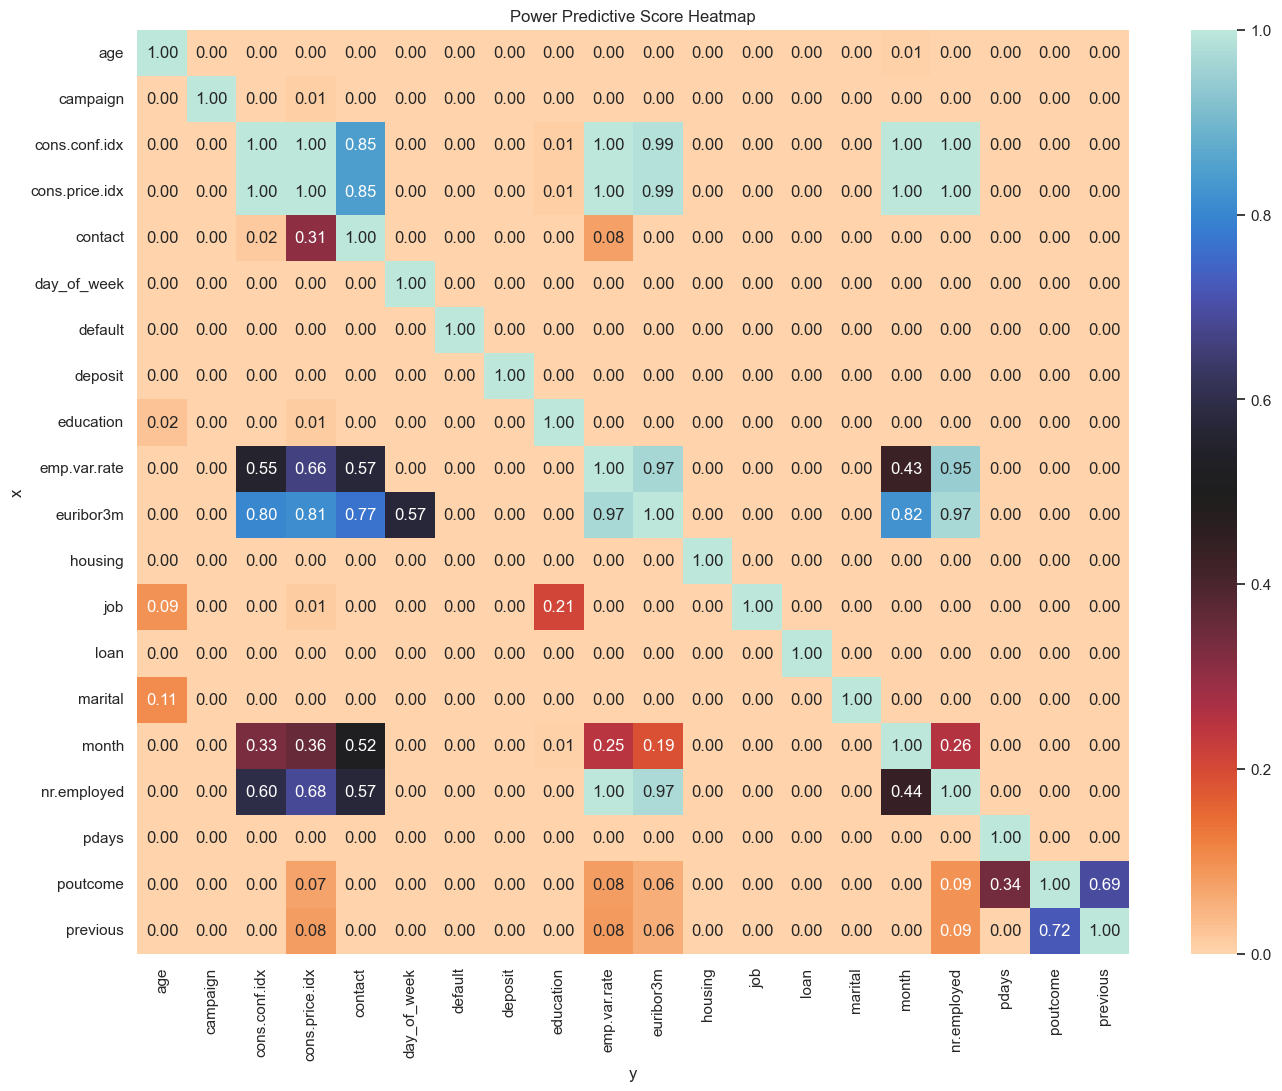

In [31]:
import ppscore as pps

# Calculate the PPS matrix
pps_matrix = pps.matrix(df_pps)

# Pivot the PPS matrix to a format suitable for heatmap
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

plt.figure(figsize=(16,12))
sns.heatmap(pps_pivot, annot=True, fmt=".2f", cmap='icefire_r')
plt.title('Power Predictive Score Heatmap')
plt.show()

In [32]:
df_selection = df2.copy()
df_selection.drop(columns=['emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed','euribor3m'], axis=1, inplace=True)

In [33]:
X_pps = df_selection.drop(['deposit'], axis=1)
y_pps = df_selection['deposit']

# split into train+val and test
X_train_val_pps, X_test_pps, y_train_val_pps, y_test_pps = train_test_split(X_pps, y_pps, test_size=0.2, stratify=y_pps, random_state= 42)

# split into train and val
X_train_pps, X_val_pps, y_train_pps, y_val_pps = train_test_split(X_train_val_pps, y_train_val_pps, test_size=0.2 ,stratify=y_train_val_pps, random_state= 42)

In [34]:
grb_model_benchmarking = [('Gradient Boosting', grb)]

In [35]:
# cv benchmarking model with pps feature selection
cv_pps_benchmarking = cv_model(X_train_pps, y_train_pps, grb_model_benchmarking, scoring="precision")
pps_eval_benchmarking = model_eval(grb_model_benchmarking,X_train_pps, X_val_pps, y_train_pps, y_val_pps)
display(cv_pps_benchmarking,pps_eval_benchmarking)

,Model,mean_precision,std_precision,training_time
0,Gradient Boosting,0.629,0.028,24.315


,Model,precision
0,Gradient Boosting,0.625


#### **5.6.3 Feature Selection Comparison**

| Metode Feature Selection | Mean Precision Score | Number of Feature     | Selected Feature                                                                                                                  |
|--------------------------|----------------------|-----------------------|-------------------------------------------------------------------------------------------------------------------------|
| RFE                      | 0.672                | 19                    | onehot__day_of_week_fri, onehot__day_of_week_mon, onehot__day_of_week_tue, onehot__day_of_week_wed, onehot__poutcome_failure, onehot__poutcome_success, onehot__default_no, onehot__contact_cellular, onehot__contact_telephone, ordinal__education, remainder__age, remainder__campaign, remainder__pdays, remainder__previous, remainder__emp.var.rate, remainder__cons.price.idx, remainder__cons.conf.idx, remainder__euribor3m, remainder__nr.employed                                                                                                   |
| PPS (Benchmarking)       | 0.629                | 14                    | age, job, marital, education, default, housing, loan, contact, month, day_of_week, campaign, pdays, previous, poutcome  |


> **Insight:** 
- The mean precision score of the model trained with features selected using RFE is higher compared to the one using features from PPS. This indicates that the features chosen by RFE are more effective in helping the model distinguish between classes in the data.
- The next step will involve conducting a final experiment using hyperparameter tuning to further enhance the model's performance.

### **5.7 Experiment 4: Gradient Boosting Hyperparameter Tuning**

#### **5.7.1 Hyperparameter Tuning All Features**

In [36]:
param_grid_grb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 3]
}

skf = StratifiedKFold(n_splits=5)
grb = GradientBoostingClassifier(random_state=0)
estimator_grb = Pipeline([
    ('transformer', preprocessor),
    ('model', grb)
])

grid_search_gbc = GridSearchCV(
    estimator=estimator_grb,
    param_grid=param_grid_grb,
    cv=skf,
    scoring='precision',
    n_jobs=-1,
    verbose=1
)

grid_search_gbc.fit(X_train1, y_train1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['marital',
                                                                          'day_of_week',
                                                                          'poutcome',
                                                                          'default',
                                                                          'contact',
                                                                          'housing',
                                                                          'loan']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'education'...
professional course    6
university degree      7
Unknown                8
None                   0
dtype: int64}]),
                                                                         ['education']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['job',
                                                                          'month'])])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__min_samples_split': [2, 3],
                         'model__n_estimators': [100, 200]},
             scoring='precision', verbose=1)

In [37]:
# Output the best parameters and the best score achieved
print("Best parameters found: ", grid_search_gbc.best_params_)
print("Best precision achieved: ", grid_search_gbc.best_score_)

Best parameters found:  {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best precision achieved:  0.7770174202576847


In [38]:
grb_cv = GradientBoostingClassifier(random_state=0, 
                                    learning_rate=0.01,
                                    max_depth=3,
                                    min_samples_split=2,
                                    n_estimators=100)

grb_tuned = [('Gradient Boosting',grb_cv)]

In [39]:
cv_tuning1 = cv_model(X_train1, y_train1, grb_tuned, scoring="precision")
tuning1_eval = model_eval(grb_tuned,X_train1, X_val1, y_train1, y_val1)
display(cv_tuning1,tuning1_eval)

,Model,mean_precision,std_precision,training_time
0,Gradient Boosting,0.779,0.052,13.699


,Model,precision
0,Gradient Boosting,0.739


#### **5.7.2 Best Estimator with RFE Selected Features**

In [40]:
best_params = grid_search_gbc.best_params_
cleaned_params = {key.replace('model__', ''): value for key, value in best_params.items()}
cleaned_params

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [41]:
# Buat model dengan parameter terbaik
best_model = GradientBoostingClassifier(**cleaned_params, random_state=0)
best_model

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [42]:
# Create the pipeline with the selected features
rfe_pipeline = Pipeline([
    ('transformer', preprocessor),
    ('scaler', scaler),
    ('rfe', RFE(estimator=best_model, n_features_to_select=len(selected_features))),
])

rfe_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital', 'day_of_week',
                                                   'poutcome', 'default',
                                                   'contact', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic 4y               2
basic 6y               3
basic 9y               4
high school            5
professional course    6
university degree      7
Unknown                8
None                   0
dtype: int64}]),
                                                  ['education']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job', 'month'])])),
                ('scaler', RobustScaler()),
                ('rfe',
                 RFE(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                          random_state=0),
                     n_features_to_select=19))])

In [43]:
cv_tuning_rfe = cross_validate(rfe_pipeline, X_train1, y_train1, cv=5, scoring='precision', return_train_score=False)
training_time = cv_tuning_rfe['fit_time'] + cv_tuning_rfe['score_time']
cv_with_rfe_feature = pd.DataFrame({
    'Model': 'Gradient Boosting',
    'Mean Precision': [cv_tuning_rfe['test_score'].mean()],
    'Std Precision': [cv_tuning_rfe['test_score'].std()],
    'Mean Training Time (s)': [training_time.mean()]
})

cv_with_rfe_feature

,Model,Mean Precision,Std Precision,Mean Training Time (s)
0,Gradient Boosting,0.777017,0.022296,50.435999


In [44]:
# Predict on the test set
y_pred_selection = rfe_pipeline.predict(X_val1)
test_precision = precision_score(y_val1, y_pred_selection)
print("Test Precision: ", test_precision)

Test Precision:  0.7391304347826086


#### **5.7.3 Best Estimator with PPS Selected Features**

In [45]:
best_model = [('Gradient Boosting',best_model)]

In [46]:
cv_tuning_pps = cv_model(X_train_pps, y_train_pps, best_model, scoring="precision")
tuning_pps_eval = model_eval(best_model,X_train_pps, X_val_pps, y_train_pps, y_val_pps)
display(cv_tuning_pps,tuning_pps_eval)

,Model,mean_precision,std_precision,training_time
0,Gradient Boosting,0.764,0.05,15.309


,Model,precision
0,Gradient Boosting,0.656


#### **5.7.4 comparison Model Tuned with Selected Features**

| Feature Selection Method | Mean Precision | Std Precision | Training Time (s) |
|--------------------------|----------------|---------------|-------------------|
| All Features             | 0.779          | 0.052         | 13.123            |
| RFE                      | 0.777          | 0.022         | 53.998            |
| PPS                      | 0.764          | 0.050         | 11.396            |

> **Insight:**

From a performance perspective, the hyperparameter-tuned model using all features achieved the highest mean precision. This suggests that the model benefits from the complete set of features, allowing for a more comprehensive representation of the data and better differentiation between classes.

However, when we consider the business aspect, particularly the training time and associated costs, we observe a significant trade-off, while All Features shows only a 0.002 difference in Precision compared to RFE, there's a substantial disparity in Training Time. All Features takes 13.123 seconds, whereas RFE takes 53.998 seconds (over 4 times longer). Longer training times require a larger budget for data training and prediction. The efficiency of the All Features method could lead to substantial savings, especially when scaling up to larger datasets or more frequent model updates. Using All Features appears to be the more cost-effective approach. It achieves slightly better precision while significantly reducing computational resources and associated costs.

Given these factors, we have decided to use the hyperparameter-tuned model with all features as our final model. This choice offers the best balance between model performance and resource utilization. It not only provides the highest precision but also allows for quicker model deployment and iteration, potentially leading to faster insights and more agile decision-making in the bank's marketing strategies.

### **5.8 Final Model Selection**

> Based on the analysis of the experimental results, the dataset with the best performance is the default dataset. Among the various models evaluated, the Gradient Boosting model emerged as the top performer. Specifically, in Experiment 4, which involved hyperparameter tuning using all available features, Gradient Boosting achieved the highest precision. This indicates that incorporating the complete set of features and optimizing hyperparameters significantly enhanced the model's ability to accurately classify and distinguish between classes. Consequently, we have selected this model as our final model, leveraging its superior performance to achieve the best possible outcomes for our analysis.

In [47]:
df = pd.read_csv('dataset_default.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39400 entries, 0 to 39399
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             39400 non-null  int64  
 1   job             39400 non-null  object 
 2   marital         39400 non-null  object 
 3   education       39400 non-null  object 
 4   default         39400 non-null  object 
 5   housing         39400 non-null  object 
 6   loan            39400 non-null  object 
 7   contact         39400 non-null  object 
 8   month           39400 non-null  object 
 9   day_of_week     39400 non-null  object 
 10  campaign        39400 non-null  int64  
 11  pdays           39400 non-null  int64  
 12  previous        39400 non-null  int64  
 13  poutcome        39400 non-null  object 
 14  emp.var.rate    39400 non-null  float64
 15  cons.price.idx  39400 non-null  float64
 16  cons.conf.idx   39400 non-null  float64
 17  euribor3m       39400 non-null 

In [48]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# split into train+val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [49]:
final_model = GradientBoostingClassifier(random_state=0, 
                                        learning_rate=0.01,
                                        max_depth=3,
                                        min_samples_split=2,
                                        n_estimators=100)

# Build the pipeline
clf_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# Fit the pipeline on the training data
clf_final.fit(X_train, y_train)
clf_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital', 'day_of_week',
                                                   'poutcome', 'default',
                                                   'contact', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic 4y               2
basic 6y               3
basic 9y               4
high school            5
professional course    6
university degree      7
Unknown                8
None                   0
dtype: int64}]),
                                                  ['education']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job', 'month'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            random_state=0))])

### **5.9 Final Model Performance**

#### **5.9.1 Metrics Performance on Test Set**

> In this section, we present the confusion matrix along with the classification report to evaluate the performance of our classification model. The confusion matrix provides a visual representation of the model's accuracy in predicting each class, while the classification report offers key metrics such as precision, recall, F1 score, and accuracy, breaking them down for each class in the dataset.

Precision on Test Set: 0.8188


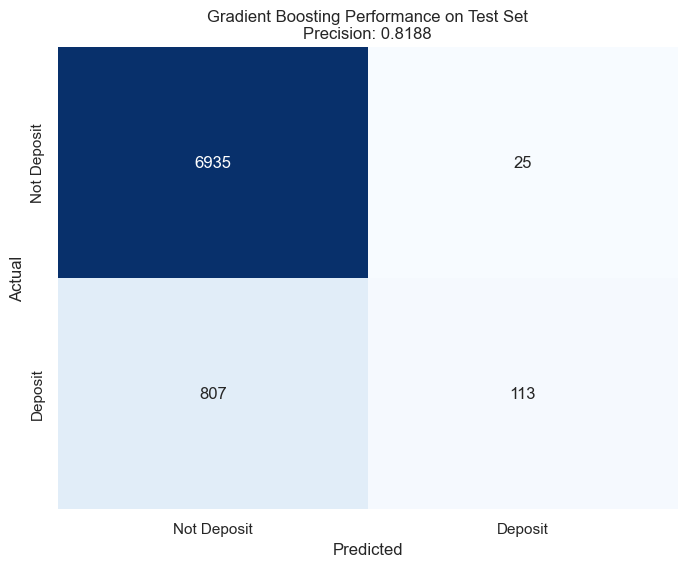

In [50]:
# predict on the test set
y_pred_test = clf_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
print(f'Precision on Test Set: {precision:.4f}')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Gradient Boosting Performance on Test Set\nPrecision: {precision:.4f}')
ax.set_xticklabels(['Not Deposit', 'Deposit'])
ax.set_yticklabels(['Not Deposit', 'Deposit'])
plt.show()

In [51]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6960
           1       0.82      0.12      0.21       920

    accuracy                           0.89      7880
   macro avg       0.86      0.56      0.58      7880
weighted avg       0.89      0.89      0.86      7880



> **Insight:** 

The model's precision for predicting potential deposit subscriptions (class 1) is 0.82, meaning 82% of predicted subscribers are correctly identified. This high precision is crucial for minimizing costs associated with targeting uninterested customers and ensures marketing efforts focus on the most promising leads. Despite a lower recall, the model's strong precision and overall accuracy of 0.90 demonstrate its effectiveness in correctly identifying likely subscribers, which is vital for our business, even if it means some potential subscribers may be missed.

#### **5.9.2 Learning Curve**

> A learning curve is a tool used to measure a machine learning model’s performance as it is exposed to more data or trained over a longer period. It typically includes two key components: the first tracks the model’s performance on the training dataset, illustrating improvements as more data is introduced; the second tracks performance on the cross-validation set, indicating how well the model handles new, unseen data. Analyzing these curves helps us determine if the model is learning well, needs more data, or is overfitting.

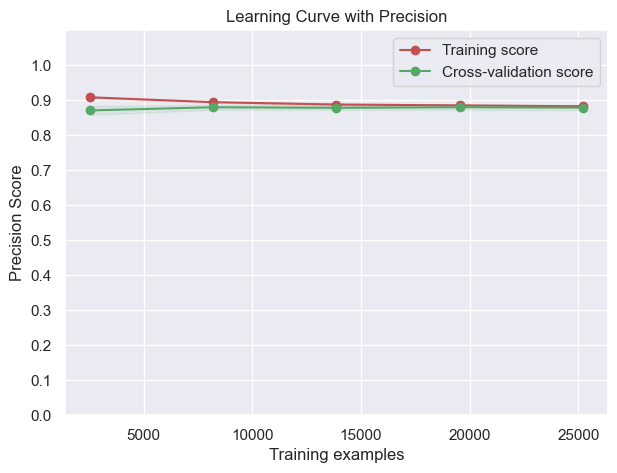

In [52]:
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import learning_curve

# Mengubah f2_scorer menjadi precision_scorer
precision_scorer = make_scorer(precision_score, average='weighted')

# Plot Learning Curve dengan precision sebagai scoring metric
train_sizes, train_scores, test_scores = learning_curve(clf_final, X_train, y_train, cv=5, scoring=precision_scorer, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=[7,5])
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Precision Score')
plt.title('Learning Curve with Precision')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()


> **Insight:** The Gradient Boosting model remains stable as more training examples are added. The training score is high and consistent, indicating strong performance on the training data. The cross-validation score gradually increases, approaching the training score. This suggests that the model is not overfitting and is effectively learning from new data.

#### **5.9.3 Feature Importance**

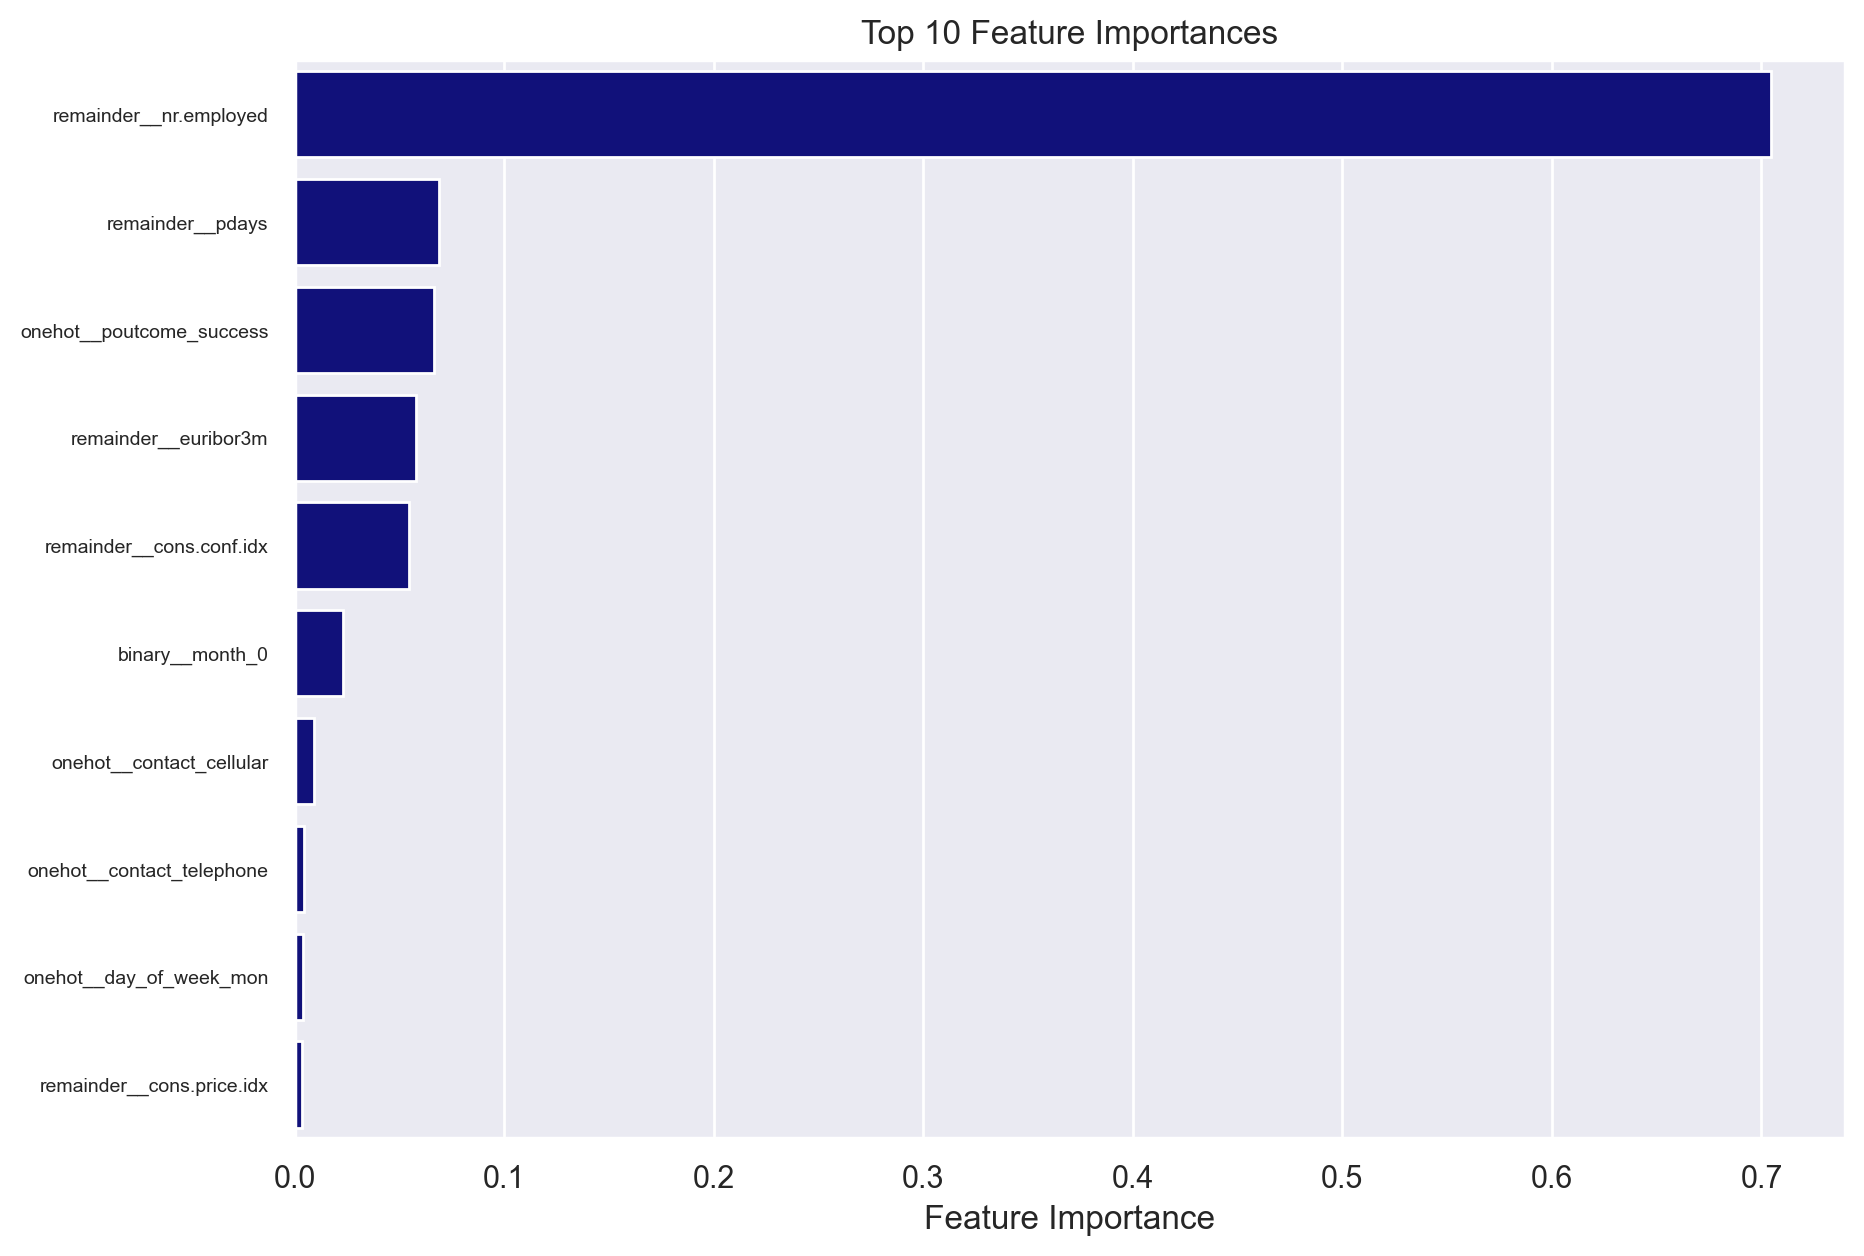

In [53]:
best_gbc_model = clf_final.named_steps['classifier']
feature_importances = best_gbc_model.feature_importances_
feature_names = clf_final.named_steps['preprocessor'].get_feature_names_out()
sorted_indices = np.argsort(feature_importances)[::-1]

top_n = 10
top_indices = sorted_indices[:top_n]

plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[top_indices], y=np.array(feature_names)[top_indices], color='darkblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.yticks(fontsize=7)
plt.show()

> The most significant features influencing the success of a term deposit marketing campaign are largely tied to broader economic indicators and timing. The Number of Employees, reflecting Portugal's overall employment levels, is the most critical factor, highlighting the influence of economic conditions on financial decisions. The Days Since Last Contact underscores the importance of timely follow-ups, while a customer's positive response to previous campaigns strongly indicates their likelihood of accepting an offer. Economic benchmarks like the 3-month Euribor Rate and the Consumer Confidence Index also play vital roles, affecting the appeal of term deposits and consumer sentiment. Additionally, the timing of contact, such as the Month of Contact and the Day of the Week, along with the method of communication, whether via cellular or traditional telephone, further influences campaign outcomes. Lastly, the Consumer Price Index adds context to these factors, rounding out the key elements that determine the success of marketing efforts.

### **5.10 Final Model Explanation**

#### **5.10.1 Gradient Boosting Works**

Gradient Boosting is a machine learning algorithm that constructs a strong predictive model by combining multiple simpler models, typically decision trees. It does this by iteratively focusing on correcting the errors made by previous models, enhancing the overall accuracy. Below is a step-by-step explanation using your dataset features:

1. Initial Prediction: Start with an initial prediction for the target outcome, such as whether a customer will subscribe to a deposit. Initially, the model might predict that no customers will subscribe.

2. First Decision Tree: Construct the first decision tree using available features like age, job, marital, education, emp.var.rate, and euribor3m to identify patterns in the data that explain whether a customer subscribes to a deposit.

3. Calculate Residuals: After the first tree makes its predictions, calculate the residuals, which are the differences between the actual outcomes (whether a customer subscribes to a deposit) and the predictions. These residuals highlight where the first tree’s predictions were inaccurate.

4. Second Decision Tree: Build the second decision tree to predict the residuals (errors) from the first tree. This tree focuses on the data points where the first model was least accurate, for example, cases where the prediction of subscription to a deposit was incorrect.

5. Iterative Process: Continue building additional trees, where each new tree is designed to correct the errors made by the previous trees. For instance, subsequent trees might focus on more nuanced features like campaign, pdays, and previous, which could impact a customer’s decision to subscribe.

6. Final Prediction: Combine all the trees to make the final prediction. The ensemble of trees collectively provides a more accurate and robust model for predicting whether a customer will subscribe to a deposit

#### **5.10.2 SHAP**

In [54]:
# Get the feature names after preprocessing
feature_names = clf_final.named_steps['preprocessor'].get_feature_names_out()
list_features = []
for feat in feature_names:
    list_features.append('_'.join(feat.split('_')[2:]))

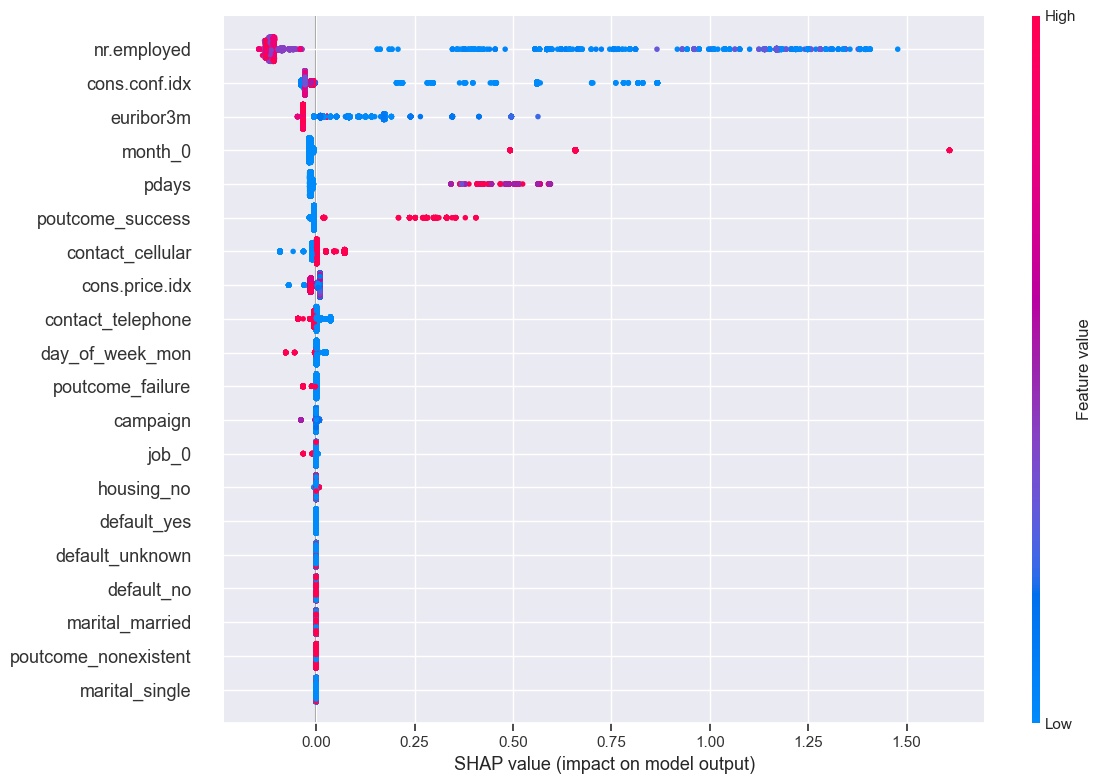

In [55]:
import shap
X_train_transformed = pd.DataFrame(
    clf_final.named_steps['preprocessor'].transform(X_train),
    columns=list_features
)

X_test_transformed = pd.DataFrame(
    clf_final.named_steps['preprocessor'].transform(X_test),
    columns=list_features
)

best_gbc_model = clf_final.named_steps['classifier']
explainer = shap.TreeExplainer(best_gbc_model, X_train_transformed)
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, 
                    feature_names=list_features, 
                    title="SHAP Summary Plot", 
                    plot_size=(12, 8))

>Insight:
- Lower employment rates (indicated by blue points on the left side) are associated with a higher likelihood of customers making a term deposit.
cons.conf.idx:
- A lower consumer confidence index (indicated by blue points) suggests a higher chance of customers opting for a term deposit.
- Lower Euribor rates (blue points) correlate with a higher probability of customers making a term deposit.
- Customers contacted earlier in the year (represented by blue points) show a stronger tendency to make a term deposit.
- A lower number of days since the last contact (blue points) is linked to a higher likelihood of customers making a term deposit.
- Customers who had a successful outcome in the previous campaign (indicated by red points) are more likely to make a term deposit.
- Contacting customers via cellular phone (represented by red points) increases the chances of them making a term deposit.
- Lower consumer price index values (blue points) are associated with a higher probability of customers making a term deposit.
- Contacting customers via a landline (blue points) is less effective in encouraging them to make a term deposit.
- Customers contacted on Monday (red points) are more likely to make a term deposit.
- A failure in the previous campaign (blue points) decreases the likelihood of a customer making a term deposit.
- Fewer contacts during the campaign (blue points) tend to lead to a higher likelihood of making a term deposit.

#### **5.10.3 Final Model Prediction**

In [56]:
# single prediction for extreme value
new_test_data = pd.DataFrame({
    "age": [83, 65],
    "job": ["retired", "blue-collar"],
    "marital": ["divorced", "single"],
    "education": ["basic.4y", "high.school"],
    "default": ["no", "yes"],
    "housing": ["no", "no"],
    "loan": ["no", "yes"],
    "contact": ["cellular", "telephone"],
    "month": ["nov", "nov"],
    "day_of_week": ["tue", "fri"],
    "campaign": [1, 1],
    "pdays": [3, 3],
    "previous": [3, 2],
    "poutcome": ["success", "success"],
    "emp.var.rate": [-3.4, -1.8],
    "cons.price.idx": [92.649, 92.201],
    "cons.conf.idx": [-30.1, -50.8],
    "euribor3m": [0.716, 1.028],
    "nr.employed": [5017.5, 5099.1]
})

# Predict probabilities and the final prediction
new_test_data['prediction'] = clf_final.predict(new_test_data)
new_test_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,prediction
0,83,retired,divorced,basic.4y,no,no,no,cellular,nov,tue,1,3,3,success,-3.4,92.649,-30.1,0.716,5017.5,1
1,65,blue-collar,single,high.school,yes,no,yes,telephone,nov,fri,1,3,2,success,-1.8,92.201,-50.8,1.028,5099.1,0


In [57]:
# bulk prediction
y_pred = clf_final.predict(X_test)
y_prob = clf_final.predict_proba(X_test)[:, 1]
predictions_df = X_test.copy()
predictions_df['Actual'] = y_test.values
predictions_df['Predicted'] = y_pred
predictions_df['Pred Probability'] = y_prob
predictions_df['Pred Probability'] = predictions_df['Pred Probability'].round(4)

In [64]:
predictions_df.to_excel('prediction_result.xls')

#### **5.11 Limitations**

In [62]:
# prepare train set
df_seen = X_train.copy()

# get overview of numerical features
df_seen.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,31520.0,40.10,10.47,17.00,32.00,38.00,47.00,98.00
campaign,31520.0,2.62,2.81,1.00,1.00,2.00,3.00,43.00
pdays,31520.0,0.23,1.38,0.00,0.00,0.00,0.00,27.00
previous,31520.0,0.18,0.50,0.00,0.00,0.00,0.00,6.00
emp.var.rate,31520.0,0.06,1.58,-3.40,-1.80,1.10,1.40,1.40
cons.price.idx,31520.0,93.58,0.58,92.20,93.08,93.80,93.99,94.77
cons.conf.idx,31520.0,-40.50,4.65,-50.80,-42.70,-41.80,-36.40,-26.90
euribor3m,31520.0,3.60,1.74,0.63,1.33,4.86,4.96,5.04
nr.employed,31520.0,5166.00,72.76,4963.60,5099.10,5191.00,5228.10,5228.10


In [63]:
# get overview of categorical features
pd.options.display.max_colwidth = 100
pd.DataFrame({
        'ColumnName': df_seen.select_dtypes(include='O').columns.values.tolist(),
        'Nrow': df_seen.select_dtypes(include='O').shape[0],
        'DataType': df_seen.select_dtypes(include='O').dtypes.values.tolist(),
        'UniqueValue': df_seen.select_dtypes(include='O').nunique().tolist(),
        'Sample': [df_seen.select_dtypes(include='O')[col].unique() for col in df_seen.select_dtypes(include='O').columns]
    })

,ColumnName,Nrow,DataType,UniqueValue,Sample
0,job,31520,object,12,"[services, blue-collar, admin, management, housemaid, student, technician, self-employed, entrep..."
1,marital,31520,object,4,"[married, single, divorced, unknown]"
2,education,31520,object,8,"[professional course, basic 9y, university degree, basic 6y, high school, basic 4y, unknown, ill..."
3,default,31520,object,3,"[no, unknown, yes]"
4,housing,31520,object,3,"[yes, no, unknown]"
5,loan,31520,object,3,"[yes, no, unknown]"
6,contact,31520,object,2,"[cellular, telephone]"
7,month,31520,object,10,"[jul, jun, may, aug, apr, nov, mar, sep, oct, dec]"
8,day_of_week,31520,object,5,"[fri, mon, thu, tue, wed]"
9,poutcome,31520,object,3,"[nonexistent, failure, success]"


The analysis and development of the predictive model faced several limitations and challenges that could impact its accuracy and reliability in certain scenarios. The Gradient Boosting model in this project was trained using 19 columns in total, consisting of 10 categorical features, 9 numerical features, and 1 target variable. All of them are specified in the dataframes above. 

- The dataset only provides limited personal financial information (like having a housing loan or personal loan) and cannot account for detailed financial profiles of customers. 
- The dataset likely covers a limited time period, potentially missing long-term economic cycles or seasonal patterns.
- Underrepresentation of certain age groups (under 17, over 75) and job categories (like entrepreneurs or students) leads to less reliable predictions
- Some months like January and February are underrepresented, leading to less accurate predictions during these periods.
- The project development time was limited to 15 days, constraining the depth of analysis and experimentation possible.
- The model cannot consider external factors not included in the dataset, such as broader market trends, competitor offerings, or individual customer financial goals.

Scenarios where the model may underperform:
- When economic indicators are unusually high or low, the model becomes less reliable. It struggles with extreme economic situations that it hasn't seen much in its training data.
- If a customer is contacted more than 15 times, the model's predictions become less trustworthy. It's not used to dealing with such intensive marketing campaigns.
- For less common job types like entrepreneurs or students, the model's predictions are not as accurate. It doesn't have enough data on these groups to make strong predictions.
- The model relies heavily on whether a customer's previous interactions were successful or not. For customers with unique past outcomes, its predictions might be off.

## **6. Conclusions and Recommendations**

In [61]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      6960
           1       0.82      0.12      0.21       920

    accuracy                           0.89      7880
   macro avg       0.86      0.56      0.58      7880
weighted avg       0.89      0.89      0.86      7880



#### **6.1 Cost Savings Calculation for Telemarketing Campaign**

From the model performance insights, the model can reduce the number of predicted decliners by 90%. Additionally, if the model predicts a customer will accept the offer, there is an 82% chance that the customer will actually accept.

Assuming the telemarketing cost is EUR 5 per customer and we are targeting 1,000 clients (with the assumption that 500 will accept the offer and 500 will decline), the cost savings calculation is as follows:

**Without the Model (Offering to All clients):**
* Total Cost: 1,000 clients x EUR 5 = EUR 5,000
* Wasted Cost: 500 clients who decline x EUR 5 = EUR 2,500

**With the Model (Offering Only to Predicted Interested clients):**
* Predicted Acceptors:
    * If the model predicts 500 clients will accept, and precision is 82%, then:
    * True Acceptors: 82% of 500 = 410 clients
    * False Acceptors: 18% of 500 = 90 clients
* Predicted Decliners:
    - Initial predicted decliners: 500
    - Reduction by 90%: 10% remaining = 50 predicted decliners
* Wasted Cost:
    - For false acceptors: 90 clients x EUR 5 = EUR 450
* Total Cost with Model : 
    - (500 + 50) clients x EUR 5 = EUR 2,750


**Total Savings:**
* Cost Without Model: EUR 5,000
* Cost With Model: EUR 2,750
* Savings Without Model: EUR 5000 - EUR 5000 = EUR 0
* Savings With Model = EUR 5,000 - EUR 2,750 = EUR 2,250


**Conclusion:**
By using the predictive model, the company can save EUR 2,250 compared to running the campaign without the model. Then, by using predictive model we only wasted cost EUR 450 which is reduce by 82% compared to the wasted cost without model. This approach reduces the number of wasted calls and targets potential clients more efficiently, thereby optimizing campaign costs.

#### **6.2 Conclusions**

In this project, we aimed to address the inefficiencies in a telemarketing campaign designed to attract term deposits. Although the current conversion rate of 11.3% can be considered "acceptable" in the financial services industry, there is significant room for improvement, especially when compared to top performers who achieve rates up to 23%. To achieve the business goal of increasing conversion rates and reducing wasteful spending, this project involved a diagnostic analysis of historical data to understand customer behavior and a series of experiments to develop a predictive model.

**Data Analysis**

Based on the Data Analysis that has been conducted, we can answer the question that we define in problem statement, what customers characteristic and interactions should we focus on to maximize conversion rates?
* Last Contact: campaign paling baik diberikan setelah 4 minggu dari campaign sebelumnya
* Interaction Frequency: Customers with some interactions in previous campaigns, have a higher likelihood of deposit. 
* Previous Campaign Result: customer who were successful in past campaigns, have a higher likelihood of deposit
* Call Duration: The longer duration of calls tends to have higher success rates of deposit.
* Age: Target customers aged between 82-90.
* Month: the best month to contact customer is on March.

**Predictive Modeling**

Our predictive modeling emphasized the importance of targeting the customers with a higher likelihood to deposit by minimizing false positives (customers predicted to make a deposit who do not) to reduce unnecessary telemarketing costs. Data that still contains `unknown` values perform better than the unknown values are filled in. We conducted four experiments to develop a predictive model using machine learning. **The best-performing model emerged from Experiment 4**, where we used Gradient Boosting with all features and applied hyperparameter tuning. This model enabled the bank to focus its campaign efforts on customers with a high likelihood of opening a deposit. As a result, **the bank can significantly increase its conversion rate, potentially boosting it around 80%**.

#### **6.2 Recomendations**

**Business Recommendation**

Recommendations for Bank Marketing Team:
- Timing: Contact customers approximately 4 weeks after the previous campaign to maximize engagement.
- Targeted Follow-Ups: Focus on customers who had some interactions in past campaigns and were successful in previous campaigns, as they have a higher likelihood of accepting the deposit offer.
- Call Strategy: Ensure that call durations are sufficiently long to improve the success rate of the deposits.
- Demographic Targeting: Prioritize reaching out to customers aged 82-90 who have shown a higher propensity for conversion.
- Campaign Scheduling: Conduct campaigns in March, as this month has been identified as the most effective for reaching potential customers.

Recommendations for Bank Financial Team:
- Allocate more of the marketing budget to high-potential customers identified by our model.

**Model and Dataset Recomendations**
- Update the customer information system to require all fields to be filled. Ensuring that the model has complete information for all customers, which should lead to more accurate predictions.
- Enhance data collection by adding features like account balance, number of dependents, and timestamps for all interactions, which will provide more context and potentially improve the model's performance by capturing time-sensitive patterns and customer value indicators.
- Try more machine learning algorithms and play around with more settings (hyperparameters) to see if we can make the model even better. Also, test other ways to balance our data, like using RandomOverSampler, to see if that helps the model learn from all types of customers more evenly.

In [59]:
# Save the final model to a file named "model_hotel_booking_cancellation.sav" using pickle
pickle.dump(clf_final, open("model_deposit_prediction.sav", "wb"))